In [2]:
!pip install geopandas
import os 
import numpy as np 
import glob 
import copy 
from datetime import datetime 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
import seaborn as sns
sns.set_theme(style='whitegrid', context='paper')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 13.3 MB/s 
     |████████████████████████████████| 6.3 MB 53.9 MB/s 
     |████████████████████████████████| 16.7 MB 49.9 MB/s 


In [7]:
def rect_intersect(r1, r2): 
  """Return True iff given rectangles intersect. 
  rectangles defined as [x_center, y_center, width, height]"""

  [x1, y1, w1, h1] = r1 
  [x2, y2, w2, h2] = r2

  x1_left = x1 - w1/2 
  x1_right = x1 + w1/2 
  x2_left = x2 - w2/2 
  x2_right = x2 + w2/2 

  # check if either is to the left of the other 
  if (x1_right < x2_left) or (x2_right < x1_left): 
    return False

  top1 = y1 + h1/2 
  bottom1 = y1 - h1/2 
  top2 = y2 + h2/2 
  bottom2 = y2 - h2/2   

  # check if either is below the other 
  if top1 < bottom2 or top2 < bottom1: 
    return False 

  return True 

def aggregate_instances(labels_dict, threshold=0): 
  """Given a dictionary of detections (created below), aggregate the 
  individual image-level predictions into events (i.e., instances)"""
  instance_dict = {}
  for loc, sdict in labels_dict.items():
    for season, ddict in sdict.items():

      dates = sorted(ddict.keys())
      
      # keep track of instances for this season
      all_instances = [] 

      for i, date in enumerate(dates): # all images in season in correct order 

        # print(i, labels_dict[loc][season][date])

        if not len(labels_dict[loc][season][date]): 
          # end all instances, this date has no labels
          for inst in all_instances: 
            if inst['active']: 
              inst['active'] = False 
              inst['end'] = dates[i-1] 
          continue

        # grab coordinates (labels), images, and confidences 
        for labels_ims in labels_dict[loc][season][date]:
          
          if len(labels_ims) == 2: 
            label_list, im = labels_ims[0], labels_ims[1]
            confs = [1]*len(label_list)
          else: 
            label_list, im = labels_ims[0], labels_ims[1]
            confs = labels_ims[2]
            conf_bools = np.array([c >= threshold for c in confs]) 
            label_list = np.array(label_list)[conf_bools]
            confs = np.array(confs)[conf_bools]
            assert len(confs) == len(label_list) == np.sum(conf_bools)


          # Check which instances get extended 
          used_labels = [] # track which labels get used  
          for inst in all_instances: 
            if not inst['active']: continue # instance already ended 
            continued = False 
            for j, coords in enumerate(label_list): 
              any_int = np.sum([rect_intersect(coords, c) for c in inst['coords']]) 
              if any_int: # this label is part of current instance 
                inst['ims'].append(im) 
                inst['coords'].append(coords)
                inst['conf'] = max(inst['conf'], confs[j]) # confidence is maximum conf over all detections
                continued = True 
                used_labels.append(j)
            if not continued: # this instance ended, no labels matched 
              inst['active'] = False 
              inst['end'] = dates[i-1] if inst['start'] < date else date

          # Make new instances from any unused labels 
          for j, coords in enumerate(label_list): 
            if j in used_labels: continue 
            new_inst = {'start': date, 
                        'active': True, 
                        'ims': [im], 
                        'coords': [coords], 
                        'conf': confs[j]}
            #print('creating new inst', date, new_inst)
            all_instances.append(new_inst)


      # End of season, so we end all instances 
      for inst in all_instances: 
        if inst['active']: 
          inst['active'] = False 
          inst['end'] = dates[-1]

      if loc not in instance_dict.keys():
        instance_dict[loc] = {}
      
      instance_dict[loc][season] = all_instances   

  return instance_dict 
def gen_box_coords(lat, lon, height=0.00450, width=0.00592):
    """
    Args:
        lat (float): latitude in decimal degrees
        lon (float): longitude in decimal degrees
        height (float): height of image in decimal degrees [default = 0.00450, appx 500m at IL latitude]
        width (float): width of image in decimal degrees [default = 0.00592, appx 500m at IL latitude]

    Returns:
        box polygon coordinates
    """

    w = width / 2
    h = height / 2

    # format is [[l, b], [r, b], [r, t], [l, t], [l, b]]

    box_coords = [[lon - w, lat - h],
                  [lon + w, lat - h],
                  [lon + w, lat + h],
                  [lon - w, lat + h],
                  [lon - w, lat - h]]

    return box_coords

In [39]:
# Create dictionary of all image dates 

test_ims = 'your/data/path/yolov5_runs/detect/'

date_dict = {}

for exp in ['exp1', 'exp2', ...]:
  for im in os.listdir(os.path.join(test_ims, exp, 'labels')):
    if not '.txt' in im:
      continue
    loc = im.split('_')[1]
    date = datetime.strptime(im.split('_')[2], '%Y%m%d')
    season = date.year if date.month > 6 else date.year - 1

    if loc not in date_dict.keys(): 
      date_dict[loc] = {2018: {}, 2019: {}, 2020: {}}

    date_dict[loc][season][date] = []

In [40]:
# Predictions
results_path = 'your/data/path/yolov5_runs/detect//detect/'

pred_labels = copy.deepcopy(date_dict)

for exp in ['exp1', 'exp2', ...]:
  for txt in os.listdir(os.path.join(results_path, exp, 'labels')): 
    loc = txt.split('_')[1]
    date = datetime.strptime(txt.split('_')[2], '%Y%m%d') 
    season = date.year if date.month > 6 else date.year - 1 
    
    with open(os.path.join(results_path, exp, 'labels', txt), 'r') as f: 
      plbls, confs = [], []
      for l in [l.strip() for l in f.readlines()]: 
        arr = l.split(' ')
        plbls.append([float(x) for x in arr[1:-1]])
        confs.append(float(arr[-1]))

    pred_labels[loc][season][date].append((plbls, txt.replace('.txt', '.png'), confs))

# ignore detections below threshold 
p_instance_dict = aggregate_instances(pred_labels, threshold=0.5)

Outlier Faciltiies Plot:

In [41]:
apps_p_season = []
n_apps = []
for loc in p_instance_dict:
  apps = 0
  for s in p_instance_dict[loc]:
    apps+=len(p_instance_dict[loc][s])
    n_apps.append(len(p_instance_dict[loc][s]))
  apps_p_season.append(apps/3)

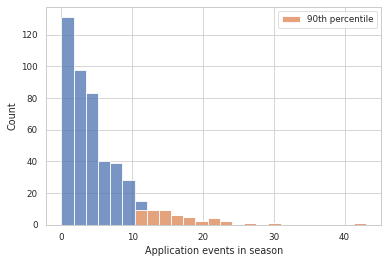

In [42]:
ninety = np.quantile(n_apps, 0.9)
df = pd.DataFrame({'n_app':n_apps, '90th percentile':[x>=ninety for x in n_apps]})
g= sns.histplot(df, x = 'n_app', bins= 25, hue='90th percentile', multiple='stack')
plt.xlabel('Application events in season')
plt.ylabel('Count')
g.legend({'90th percentile':'90th percentile'})
plt.savefig('apps_season_hist.png', dpi=300, bbox_inches='tight')
plt.show()

Collect Applicaion date information:

In [43]:
time_since_last_instance = []
app_dates = []
locs = []
for loc in tqdm(p_instance_dict):
  for season in p_instance_dict[loc]:
    starts = []
    for app in p_instance_dict[loc][season]:
      app_dates.append(app['start'])
      locs.append(loc)
      starts.append(app['start'])

    starts = sorted(starts)
    deltas = []
    for i in range(1,len(starts)):
      #if starts[i] == starts[i-1]:
      #  continue
      #else:
      deltas.append(starts[i]-starts[i-1])
      
    time_since_last_instance += deltas

  0%|          | 0/158 [00:00<?, ?it/s]

Time between events:

Text(0, 0.5, 'number of application instances')

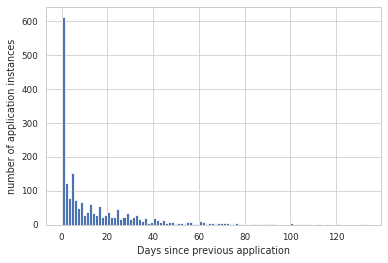

In [44]:
days_since_last_app = [delta.days for delta in time_since_last_instance]

plt.hist(days_since_last_app, bins= 100, log=False)
plt.xlabel('Days since previous application')
plt.ylabel('number of application instances')

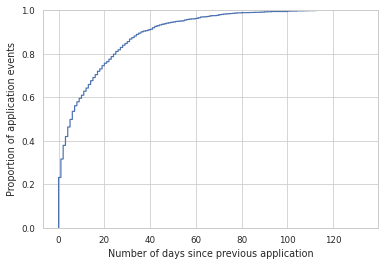

In [45]:
sns.ecdfplot(days_since_last_app)

plt.ylabel("Proportion of application events")
plt.xlabel("Number of days since previous application")

plt.savefig('days_between_cdf.png', dpi=300, bbox_inches='tight')
plt.show()

Weekly application trend

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


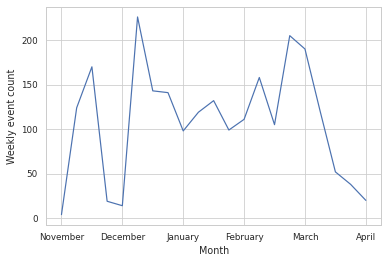

In [46]:
from math import ceil
import datetime as dt


df = pd.DataFrame({'date':app_dates, 'app':1}).set_index('date')

def get_week_of_month(date):
  #https://stackoverflow.com/questions/3806473/week-number-of-the-month
    """ Returns the week of the month for the specified date.
    """

    first_day = date.replace(day=1)

    dom = date.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

weekly = df.resample('1W').sum()

weekly['month'] = weekly.index.month
weekly['week'] = weekly.index.week
weekly['month'] = pd.Categorical(weekly['month'], [11, 12, 1, 2, 3, 4])
weekly['week']= pd.Categorical(weekly['week'], [i+44 for i in range(8)]+[i for i in range(1, 14)])
weekly.groupby(['week']).app.sum().plot()
plt.xticks([0, 4, 8, 12, 16, 20], ['November', 'December', 'January', 'February', 'March', 'April'])
plt.xlabel('Month')
plt.ylabel('Weekly event count')
plt.savefig('./app_weekly_pattern.png', dpi=300, bbox_inches='tight')
plt.show()

Percent of time with application on field

In [47]:
days_of_app = []
pct_of_app = []
loc_mean_app_pct = []
for loc in tqdm(p_instance_dict):
  time_covered= []
  pct_covered = []
  for season in p_instance_dict[loc]:
    days_in_season = (datetime(int(season)+1, 3, 31) - datetime(int(season), 11, 1)).days
    ends = [datetime(int(season), 11, 1)]
    app_days = 0
    if len(p_instance_dict[loc][season]) == 0:
      continue
    applications = pd.DataFrame(p_instance_dict[loc][season]).sort_values('start')
    for i, app in applications.iterrows():
      if app['start'] <= sorted(ends)[-1]:
        days_over = (app['end'] - sorted(ends)[-1]).days
        if days_over>0:
          app_days+= days_over
          ends.append(app['end'])
      else:
        app_days+=(app['end'] - app['start']).days
        ends.append(app['end'])

    time_covered.append(app_days)
    pct_covered.append(app_days/days_in_season)
  days_of_app+=time_covered
  pct_of_app+=pct_covered
  loc_mean_app_pct.append(np.mean(pct_of_app))

  0%|          | 0/158 [00:00<?, ?it/s]

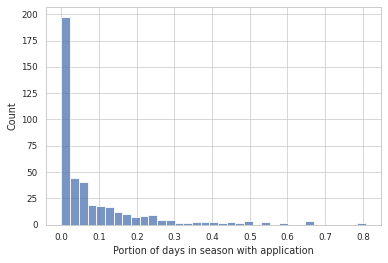

In [48]:
sns.histplot(pct_of_app, bins=35, )
plt.xlabel('Portion of days in season with application')
plt.ylabel('Count')
plt.savefig('coverage_hist.png', bbox_inches='tight', dpi=300)